## **prithivMLmods/Gliese-OCR-7B-Post1.0(4bit)**

The [Gliese-OCR-7B-Post1.0](https://huggingface.co/prithivMLmods/Gliese-OCR-7B-Post1.0) model is a fine-tuned version of Camel-Doc-OCR-062825, optimized for Document Retrieval, Content Extraction, and Analysis Recognition. Built on top of the Qwen2.5-VL architecture, this model enhances document comprehension capabilities with focused training on the Opendoc2-Analysis-Recognition dataset for superior document analysis and information extraction tasks.

> This model shows significant improvements in LaTeX rendering and Markdown rendering for OCR tasks.

*multimodal model & notebook by : [prithivMLmods](https://huggingface.co/prithivMLmods)*

### **Installing all necessary packages**

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git \
             git+https://github.com/huggingface/accelerate.git \
             git+https://github.com/huggingface/peft.git \
             transformers-stream-generator huggingface_hub albumentations \
             pyvips-binary qwen-vl-utils sentencepiece opencv-python docling-core \
             python-docx torchvision safetensors matplotlib num2words \

!pip install xformers requests pymupdf hf_xet spaces pyvips pillow gradio \
             einops torch fpdf timm av decord bitsandbytes reportlab
#Hold tight, this will take around 1-2 minutes.

### **Run Gliese-OCR-7B-Post1.0(4bit) Demo**

In [ ]:
import gradio as gr
import spaces
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, TextIteratorStreamer, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image
import os
import uuid
import io
from threading import Thread
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Image as RLImage, Paragraph, Spacer
from reportlab.lib.units import inch
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
import docx
from docx.enum.text import WD_ALIGN_PARAGRAPH

# Define model options
MODEL_OPTIONS = {
    "Gliese-OCR-7B-Post1.0": "prithivMLmods/Gliese-OCR-7B-Post1.0",
}

# Define 4-bit quantization configuration
# This config will load the model in 4-bit to save VRAM.
# You can customize these settings as needed.
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Preload models and processors into CUDA
models = {}
processors = {}
for name, model_id in MODEL_OPTIONS.items():
    print(f"Loading {name}🤗. This will use 4-bit quantization to save VRAM.")
    models[name] = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        model_id,
        trust_remote_code=True,
        quantization_config=quantization_config,
        device_map="auto"
    )
    processors[name] = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

image_extensions = Image.registered_extensions()

def identify_and_save_blob(blob_path):
    """Identifies if the blob is an image and saves it."""
    try:
        with open(blob_path, 'rb') as file:
            blob_content = file.read()
            try:
                Image.open(io.BytesIO(blob_content)).verify()  # Check if it's a valid image
                extension = ".png"  # Default to PNG for saving
                media_type = "image"
            except (IOError, SyntaxError):
                raise ValueError("Unsupported media type. Please upload a valid image.")

            filename = f"temp_{uuid.uuid4()}_media{extension}"
            with open(filename, "wb") as f:
                f.write(blob_content)

            return filename, media_type

    except FileNotFoundError:
        raise ValueError(f"The file {blob_path} was not found.")
    except Exception as e:
        raise ValueError(f"An error occurred while processing the file: {e}")

@spaces.GPU
def qwen_inference(model_name, media_input, text_input=None):
    """Handles inference for the selected model."""
    model = models[model_name]
    processor = processors[model_name]

    if isinstance(media_input, str):
        media_path = media_input
        if media_path.endswith(tuple([i for i in image_extensions.keys()])):
            media_type = "image"
        else:
            try:
                media_path, media_type = identify_and_save_blob(media_input)
            except Exception as e:
                raise ValueError("Unsupported media type. Please upload a valid image.")

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": media_type,
                    media_type: media_path
                },
                {"type": "text", "text": text_input},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    streamer = TextIteratorStreamer(
        processor.tokenizer, skip_prompt=True, skip_special_tokens=True
    )
    generation_kwargs = dict(inputs, streamer=streamer, max_new_tokens=1024)

    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()

    buffer = ""
    for new_text in streamer:
        buffer += new_text
        # Remove <|im_end|> or similar tokens from the output
        buffer = buffer.replace("<|im_end|>", "")
        yield buffer

def format_plain_text(output_text):
    """Formats the output text as plain text without LaTeX delimiters."""
    # Remove LaTeX delimiters and convert to plain text
    plain_text = output_text.replace("\\(", "").replace("\\)", "").replace("\\[", "").replace("\\]", "")
    return plain_text

def generate_document(media_path, output_text, file_format, font_size, line_spacing, alignment, image_size):
    """Generates a document with the input image and plain text output."""
    plain_text = format_plain_text(output_text)
    if file_format == "pdf":
        return generate_pdf(media_path, plain_text, font_size, line_spacing, alignment, image_size)
    elif file_format == "docx":
        return generate_docx(media_path, plain_text, font_size, line_spacing, alignment, image_size)

def generate_pdf(media_path, plain_text, font_size, line_spacing, alignment, image_size):
    """Generates a PDF document."""
    filename = f"output_{uuid.uuid4()}.pdf"
    doc = SimpleDocTemplate(
        filename,
        pagesize=A4,
        rightMargin=inch,
        leftMargin=inch,
        topMargin=inch,
        bottomMargin=inch
    )
    styles = getSampleStyleSheet()
    styles["Normal"].fontSize = int(font_size)
    styles["Normal"].leading = int(font_size) * line_spacing
    styles["Normal"].alignment = {
        "Left": 0,
        "Center": 1,
        "Right": 2,
        "Justified": 4
    }[alignment]

    story = []

    # Add image with size adjustment
    image_sizes = {
        "Small": (200, 200),
        "Medium": (400, 400),
        "Large": (600, 600)
    }
    img = RLImage(media_path, width=image_sizes[image_size][0], height=image_sizes[image_size][1])
    story.append(img)
    story.append(Spacer(1, 12))

    # Add plain text output
    text = Paragraph(plain_text, styles["Normal"])
    story.append(text)

    doc.build(story)
    return filename

def generate_docx(media_path, plain_text, font_size, line_spacing, alignment, image_size):
    """Generates a DOCX document."""
    filename = f"output_{uuid.uuid4()}.docx"
    doc = docx.Document()

    # Add image with size adjustment
    image_sizes = {
        "Small": docx.shared.Inches(2),
        "Medium": docx.shared.Inches(4),
        "Large": docx.shared.Inches(6)
    }
    doc.add_picture(media_path, width=image_sizes[image_size])
    doc.add_paragraph()

    # Add plain text output
    paragraph = doc.add_paragraph()
    paragraph.paragraph_format.line_spacing = line_spacing
    paragraph.paragraph_format.alignment = {
        "Left": WD_ALIGN_PARAGRAPH.LEFT,
        "Center": WD_ALIGN_PARAGRAPH.CENTER,
        "Right": WD_ALIGN_PARAGRAPH.RIGHT,
        "Justified": WD_ALIGN_PARAGRAPH.JUSTIFY
    }[alignment]
    run = paragraph.add_run(plain_text)
    run.font.size = docx.shared.Pt(int(font_size))

    doc.save(filename)
    return filename

# CSS for output styling
css = """
  #output {
    height: 500px;
    overflow: auto;
    border: 1px solid #ccc;
  }
.submit-btn {
    background-color: #cf3434  !important;
    color: white !important;
}
.submit-btn:hover {
    background-color: #ff2323 !important;
}
.download-btn {
    background-color: #35a6d6 !important;
    color: white !important;
}
.download-btn:hover {
    background-color: #22bcff !important;
}
"""

# Gradio app setup
with gr.Blocks(css=css, theme="bethecloud/storj_theme") as demo:
    gr.Markdown("# **Gliese-OCR-7B-Post1.0(4-bit)**")

    with gr.Tab(label="Image Input"):

        with gr.Row():
            with gr.Column():
                model_choice = gr.Dropdown(
                    label="Model Selection",
                    choices=list(MODEL_OPTIONS.keys()),
                    value="Gliese-OCR-7B-Post1.0"
                )
                input_media = gr.File(
                    label="Upload Image", type="filepath"
                )
                text_input = gr.Textbox(label="Question", value="Perform OCR on the image precisely")
                submit_btn = gr.Button(value="Submit", elem_classes="submit-btn")

            with gr.Column():
                output_text = gr.Textbox(label="Output Text", lines=7)

                with gr.Accordion("Plain Text", open=False):
                  plain_text_output = gr.Textbox(label="Standardized Plain Text", lines=10)

        submit_btn.click(
            qwen_inference, [model_choice, input_media, text_input], [output_text]
        ).then(
            lambda output_text: format_plain_text(output_text), [output_text], [plain_text_output]
        )

        with gr.Accordion("Docx/PDF Settings", open=False):
          with gr.Row():
              with gr.Column():
                  line_spacing = gr.Dropdown(
                      choices=[0.5, 1.0, 1.15, 1.5, 2.0, 2.5, 3.0],
                      value=1.5,
                      label="Line Spacing"
                  )
                  font_size = gr.Dropdown(
                      choices=["8", "10", "12", "14", "16", "18", "20", "22", "24"],
                      value="16",
                      label="Font Size"
                  )
                  alignment = gr.Dropdown(
                      choices=["Left", "Center", "Right", "Justified"],
                      value="Justified",
                      label="Text Alignment"
                  )
                  image_size = gr.Dropdown(
                      choices=["Small", "Medium", "Large"],
                      value="Medium",
                      label="Image Size"
                  )
                  file_format = gr.Radio(["pdf", "docx"], label="File Format", value="pdf")

        get_document_btn = gr.Button(value="Get Document", elem_classes="download-btn")

        get_document_btn.click(
            generate_document, [input_media, output_text, file_format, font_size, line_spacing, alignment, image_size], gr.File(label="Download Document")
        )

demo.launch(debug=True)

### **Demo Inference**

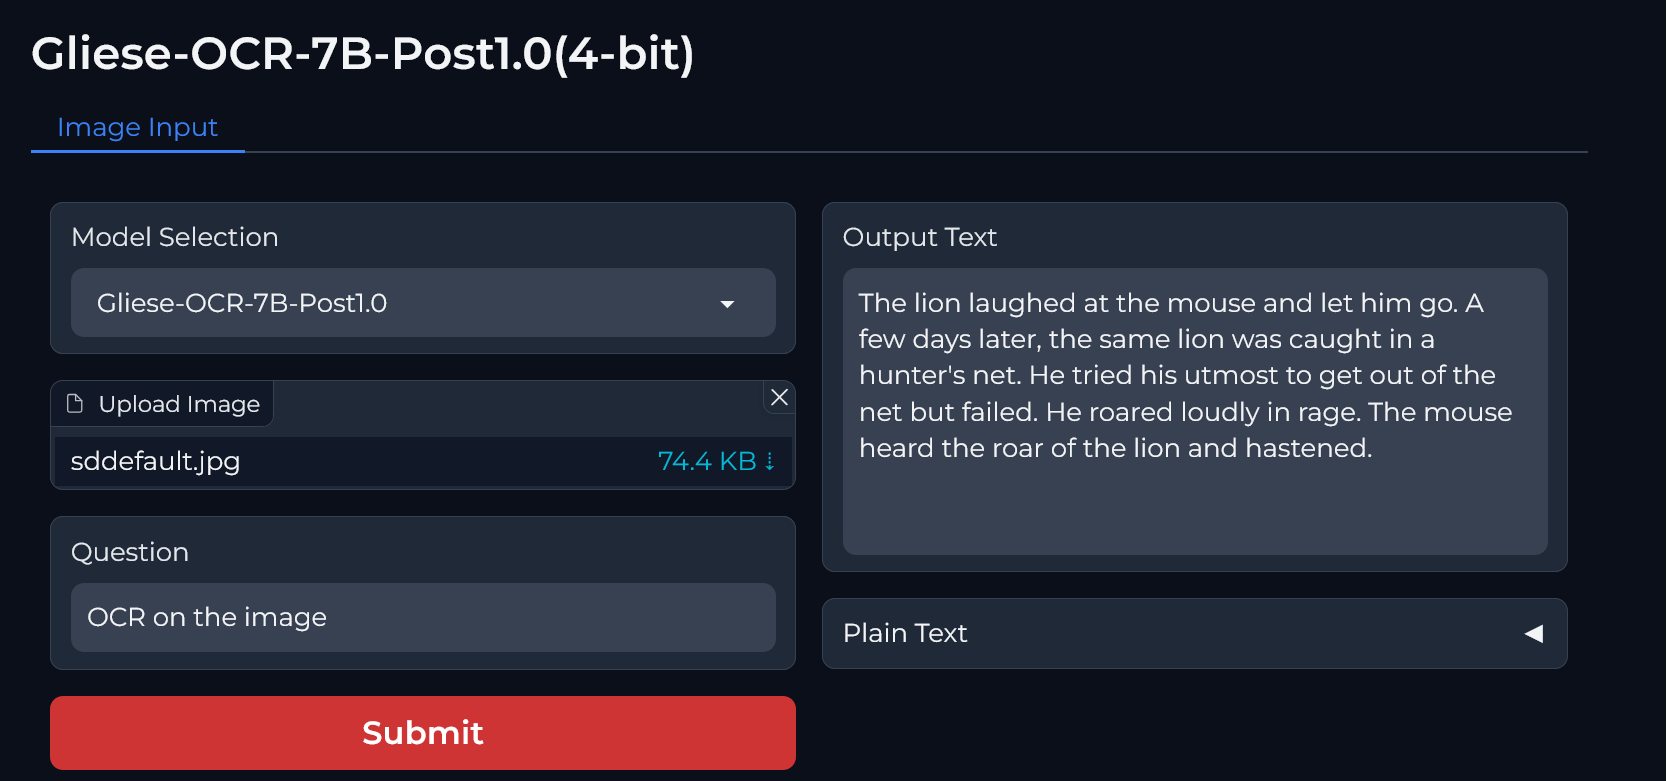